# Control code for the SHNO measurement setup

In [ ]:
#import livbraries and necesary fundtions for the script to run
import sys; sys.path.append("C:/Users/SpinAge_SHNO/OneDrive - Aarhus universitet/VS/SpinAge/Setup_control")
from shno_lib import *
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import h5py

# Initilize the intruments
magnet = rs_hmp_psu()             # Default COM port
lna_psu = keysight36300()         # Default IP
shno_bias = keithley2450(addr=2)  # IP Connection
vxm = Velmex_VXM()                # Default COM port
fsv = rs_fsv()                    # Default IP  

HAMEG,HMP2030,019170510,HW50010002/SW2.41

IDN: Keysight Technologies,E36312A,MY58051624,2.0.6-1.0.3-1.10

KEITHLEY INSTRUMENTS,MODEL 2450,04411715,1.7.12b

VXM status R
Rohde&Schwarz,FSV-30,1307.9002K30/101753,1.71 SP5



In [11]:
# Turn off all power
lna_psu.off()
shno_bias.off()
magnet.off()


In [ ]:
# Control angle. Move to 118 for microscpe clearance.
# note that the angle is move din relative terms
vxm.Move_degree(-18-23, speed=2000)

In [ ]:
# set the parameters for manually checking the probe landing
shno_bias.set_output(I=1e-3, V=2, turn_on=False)

## Magnetic field sweep

In [10]:
# initialize the parameteters

# Metadata
sample_name = "X6_L3R6"
date = time.localtime()[1:3]
date = f"{date[0]}-{date[1]}"

# Angle: 82 degrees
bias_current = 7.5e-3 # SHNO bias: 180nm: 2.2mA, 150nm: 2mA
shno_bias.set_output(I=bias_current, V=2, turn_on=False)

# Set magnet range in output current
start_field = 2     #[A]
stop_field = 4.5      #[A]
step_size = 0.01    #[A]

magnet_range = np.linspace(start_field, stop_field, int(abs((stop_field-start_field)/step_size)+1))
applied_field = np.zeros_like(magnet_range)

# Turn on FSV

start_f = 3E9; stop_f = 9E9
bandwidth = 500E3
capture_points = int(2*(stop_f-start_f)/bandwidth/2)

waveforms = np.zeros((len(magnet_range), capture_points))
waveforms_bg = np.zeros_like(waveforms)
fsv.show_screen(start_f = start_f, stop_f = stop_f, bandwidth=bandwidth, points = capture_points)
frequency = np.linspace(start_f, stop_f, capture_points)



In [11]:
# Start measurements
lna_psu.lna(state=True)
shno_bias.on()
time.sleep(1)

progress_bar = tqdm(enumerate(magnet_range), total=len(magnet_range))

mag_R = magnet.set_calibrated_current(start_field)

for i, field in progress_bar:
    mag_R = magnet.set_calibrated_current(field, mag_R)
    
    time.sleep(1)
    applied_field[i] = magnet.field_strenght()
    progress_bar.set_postfix({'Applied Field': applied_field[i]})
    waveforms[i] = fsv.get_trace(avg_count=50)

# Turn off all power
lna_psu.lna(state=False)
shno_bias.off()
magnet.off()
shno_bias.chirp(0)


  0%|          | 0/251 [00:00<?, ?it/s]

In [ ]:
# Save the data
name = f'field_sweep/{date}_{sample_name}_{str(bias_current*1000).replace(".", "_")}mA_77deg.h5'
ans = input(f"Confirm saving? [y/n]:{name}")
if ans == 'y':
    with h5py.File(name, 'w') as f:
        # Store the waveforms, frequency, and applied field
        f.create_dataset('frequency', data=frequency)
        f.create_dataset('waveforms', data=waveforms)
        f.create_dataset('applied_field', data=applied_field)
    print(f"File saved as: '{name}'")
    print("Time:", time.strftime("%H:%M:%S", time.localtime()))
else: 
    print("Save cancelled!")

## Angle Sweep

In [26]:
# Reset position
vxm.Move_degree(-5)

In [27]:
# initialize the parameteters

# Metadata
sample_name = "X6_L3R6"
date = time.localtime()[1:3]
date = f"{date[0]}-{date[1]}"

# Angle: 82 degrees
bias_current = 6.7e-3 # SHNO bias: 180nm: 2.2mA, 150nm: 2mA
shno_bias.set_output(I=bias_current, V=2, turn_on=False)

# Set magnet current 
magnet_current = 3.6 #[A] #3.3A = 0.5 T


# Angle
total_angle = 10
step_size = 0.03
angle_steps = int(total_angle/step_size)
angle_range = np.linspace(0, total_angle, angle_steps)

applied_field = np.zeros(angle_steps)

# Turn on FSV
start_f = 3E9; stop_f = 10E9
bandwidth = 500E3           # noise floor approx -80dBm @ 500e3
capture_points = int(2*(stop_f-start_f)/bandwidth)

waveforms = np.zeros((angle_steps, capture_points))
fsv.show_screen(start_f = start_f, stop_f = stop_f, bandwidth=bandwidth, points = capture_points)
frequency = np.linspace(start_f, stop_f, capture_points)



In [ ]:
# Start measurements
lna_psu.lna(state=True)
shno_bias.on()
time.sleep(1)

mag_R = magnet.set_calibrated_current(magnet_current)

for i in tqdm(range(angle_steps)):
    
    mag_R = magnet.set_calibrated_current(magnet_current, mag_R)

    applied_field[i] = magnet.field_strenght()
    waveforms[i] = fsv.get_trace(avg_count=50)
    
    vxm.Move_degree(step_size)
    shno_bias.on()
    time.sleep(0.5)

# Turn off all power
lna_psu.lna(state=False)
shno_bias.off()
magnet.off()
shno_bias.chirp(0)

  0%|          | 0/333 [00:00<?, ?it/s]

In [30]:
# Save the data
name = f'angle_sweep/{date}_{sample_name}_{str(bias_current*1000).replace(".", "_")}mA_3_6A.h5'
ans = input(f"Confirm saving? [y/n]:{name}")
if ans == 'y':
    with h5py.File(name, 'w') as f:
        # Store the waveforms, frequency, and applied field
        f.create_dataset('frequency', data=frequency)
        f.create_dataset('waveforms', data=waveforms)
        f.create_dataset('applied_field', data=applied_field)
        f.create_dataset('angle_range', data=angle_range)
    print(f"File saved as: '{name}'")
    print("Time:", time.strftime("%H:%M:%S", time.localtime()))
else: 
    print("Save cancelled!")

File saved as: 'angle_sweep/3-21_X6_L3R6_6_7mA_3_6A.h5'
Time: 15:09:04


## Bias sweep

In [13]:
# initialize the parameteters

# Metadata
sample_name = "X6_L3R5"
date = time.localtime()[1:3]
date = f"{date[0]}-{date[1]}"

# Angle: 82 degrees

# Set magnet range in output voltage
magnet_field = 3.6#3.3A = 0.5 mT

# Set bias current range
start_bias = 3e-3
stop_bias = 8.4e-3
bias_step = 0.02e-3

total_steps = int((stop_bias-start_bias)/bias_step)+1
bias_range = np.linspace(start_bias, stop_bias, total_steps)
applied_field = np.zeros_like(bias_range)

# Turn on FSV
start_f = 3E9; stop_f = 9E9
bandwidth = 500E3
capture_points = int(2*(stop_f-start_f)/bandwidth)

waveforms = np.zeros((total_steps, capture_points))
fsv.show_screen(start_f = start_f, stop_f = stop_f, bandwidth=bandwidth, points = capture_points)
frequency = np.linspace(start_f, stop_f, capture_points)


In [ ]:
# Start measurements
lna_psu.lna(state=True)
mag_R = 2 # Initial resistance

for i in tqdm(range(total_steps)):
    mag_R = magnet.set_calibrated_current(magnet_field, mag_R)
    shno_bias.set_output(2, bias_range[i], turn_on=True)
    shno_bias.on()
    time.sleep(1)
    applied_field[i] = magnet.field_strenght()
    waveforms[i] = fsv.get_trace(avg_count=50)

# Turn off all power
lna_psu.lna(state=False)
shno_bias.off()
magnet.off()
shno_bias.chirp(0)

  0%|          | 0/270 [00:00<?, ?it/s]

In [ ]:
# Save the data
name = f'bias_sweep/{date}_{sample_name}_75deg_field_3_6A.h5'
ans = input(f"Confirm saving? [y/n]:{name}")
if ans == 'y':
    with h5py.File(name, 'w') as f:
        # Store the waveforms, frequency, and applied field
        f.create_dataset('frequency', data=frequency)
        f.create_dataset('waveforms', data=waveforms)
        f.create_dataset('applied_field', data=applied_field)
        f.create_dataset('bias_range', data=bias_range)
    print(f"File saved as: '{name}'")
    print("Time:", time.strftime("%H:%M:%S", time.localtime()))
else: 
    print("Save cancelled!")

File saved as: 'bias_sweep/3-21_X6_L3R6_77deg_field_3_6A.h5'
Time: 12:01:17


## Angle/Field sweep

In [16]:
vxm.Move_degree(1.5,speed=1600)

In [25]:
# initialize the parameteters

# Metadata
sample_name = "X6_L2R6"
date = time.localtime()[1:3]
date = f"{date[0]}-{date[1]}"


bias_current = 2.0e-3 # SHNO bias: 180nm: 2.2mA, 150nm: 2mA
shno_bias.set_output(I=bias_current, V=2, turn_on=False)

# Set magnet range in current
start_field = 3.0
stop_field = 4.9
step_size = 0.05

magnet_range = np.linspace(start_field, stop_field, int(abs((stop_field-start_field)/step_size)+1))
applied_field = np.zeros_like(magnet_range)


# Angle
start_angle = 80 # set mnually 

total_angle = 6
step_size = 0.25
angle_steps = int(total_angle/step_size)
angle_range = np.linspace(0, total_angle, angle_steps+1)

# Turn on FSV
start_f = 3E9; stop_f = 9E9
bandwidth =750E3
capture_points = int(2*(stop_f-start_f)/bandwidth)

waveforms = np.zeros((len(magnet_range), capture_points))
waveforms_bg = np.zeros_like(waveforms)
fsv.show_screen(start_f = start_f, stop_f = stop_f, bandwidth=bandwidth, points = capture_points)
frequency = np.linspace(start_f, stop_f, capture_points)


In [26]:
# Start measurements
lna_psu.lna(state=True)
shno_bias.on()
time.sleep(1)

for angle in tqdm(angle_range):

    progress_bar = tqdm(enumerate(magnet_range), total=len(magnet_range), leave=False)
    mag_R = magnet.set_calibrated_current(start_field)
    for i, field in progress_bar:
        mag_R = magnet.set_calibrated_current(field, mag_R)
        applied_field[i] = magnet.field_strenght()
        progress_bar.set_postfix({'Applied Field': applied_field[i]})
        waveforms[i] = fsv.get_trace(avg_count=50)
        
    # Save the data
    name = f'angle_sweep/field_sweep/{sample_name}/{date}_{str(bias_current*1000).replace(".", "_")}mA_{angle + start_angle}deg.h5'
    with h5py.File(name, 'w') as f:
        # Store the waveforms, frequency, and applied field
        f.create_dataset('frequency', data=frequency)
        f.create_dataset('waveforms', data=waveforms)
        f.create_dataset('applied_field', data=applied_field)


    vxm.Move_degree(step_size)
    
    
# Turn off all power
lna_psu.lna(state=False)
shno_bias.off()
magnet.off()
shno_bias.chirp(0)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

## Field + Bias Sweep

In [ ]:
# initialize the parameteters

# Metadata
sample_name = "X6_L3R5"
date = time.localtime()[1:3]
date = f"{date[0]}-{date[1]}"


# Set bias current range
start_bias = 4e-3
stop_bias = 8e-3
bias_step = 0.5e-3

total_steps = int((stop_bias-start_bias)/bias_step)
bias_range = np.linspace(start_bias, stop_bias, total_steps)

#applied_field = np.zeros_like(bias_range)


# Set magnet range in output voltage
start_field = 2 #[A]
stop_field = 4.5  #[A]
step_size = 0.15



magnet_range = np.linspace(start_field, stop_field, int(abs((stop_field-start_field)/step_size)+1))
applied_field = np.zeros_like(magnet_range)



#applied_field = np.zeros(angle_steps)

# Turn on FSV
start_f = 3E9; stop_f = 9E9
bandwidth = 500E3
capture_points = int(2*(stop_f-start_f)/bandwidth)

waveforms = np.zeros((len(magnet_range), capture_points))
waveforms_bg = np.zeros_like(waveforms)
fsv.show_screen(start_f = start_f, stop_f = stop_f, bandwidth=bandwidth, points = capture_points)
frequency = np.linspace(start_f, stop_f, capture_points)


In [9]:
# Start measurements

lna_psu.lna(state=True)
shno_bias.on()
time.sleep(1)




mag_R = magnet.set_calibrated_current(start_field)

for bias_current in tqdm(bias_range):
    # set the new bias current
    shno_bias.set_output(I=bias_current, V=2, turn_on=True) 
    

    
    
    progress_bar = tqdm(enumerate(magnet_range), total=len(magnet_range), leave=False)
    for i, field in progress_bar:
        
        mag_R = magnet.set_calibrated_current(field, mag_R)
        
        applied_field[i] = magnet.field_strenght()
        progress_bar.set_postfix({'Applied Field': applied_field[i]})
        waveforms[i] = fsv.get_trace(avg_count=50)
    

    # Save the data
    #name = f'bias_sweep/field_sweep/{date}_{sample_name}_{str(np.round(bias_current*1000, 2)).replace(".", "_")}mA_82deg.h5'
    name = f"bias_sweep/field_sweep_76_L3R6/{date}_{sample_name}_" + "{:0.2f}".format((bias_current*1000)) + "_mA.h5"
    with h5py.File(name, 'w') as f:
        # Store the waveforms, frequency, and applied field
        f.create_dataset('frequency', data=frequency)
        f.create_dataset('waveforms', data=waveforms)
        f.create_dataset('applied_field', data=applied_field)
    
    
# Turn off all power
lna_psu.lna(state=False)
shno_bias.off()
magnet.off()
shno_bias.chirp(0)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

## Saving data

In [14]:
# Save the data
name = f'field_sweep/{date}_{sample_name}_{str(bias_current*1000).replace(".", "_")}mA_77_deg.h5'
ans = input(f"Confirm saving? [y/n]:{name}")
if ans == 'y':
    with h5py.File(name, 'w') as f:
        # Store the waveforms, frequency, and applied field
        f.create_dataset('frequency', data=frequency)
        f.create_dataset('waveforms', data=waveforms)
        f.create_dataset('applied_field', data=applied_field)
        #f.create_dataset('angle', data=angle_range)
        #f.create_dataset('bias_range', data=bias_range)
    print(f"File saved as: '{name}'")
    print("Time:", time.strftime("%H:%M:%S", time.localtime()))
else: 
    print("Save cancelled!")

File saved as: 'field_sweep/3-21_X6_L3R6_7_5mA_77_deg.h5'
Time: 10:27:28


In [62]:
# Load data
name = './angle_sweep/field_sweep/X6_L1R2/3-13_2_0mA_80.0deg.h5'
ans = input("Confirm loading? [y/n]")
if ans == 'y':
    with h5py.File(name, 'r') as f:
        applied_field = f['applied_field'][:]
        waveforms = f['waveforms'][:]
        frequency = f['frequency'][:]
    print("Data loaded!")
    print("Time:", time.strftime("%H:%M:%S", time.localtime()))
else: 
    print("Loading cancelled!")
    

Loading cancelled!


## Visualizations

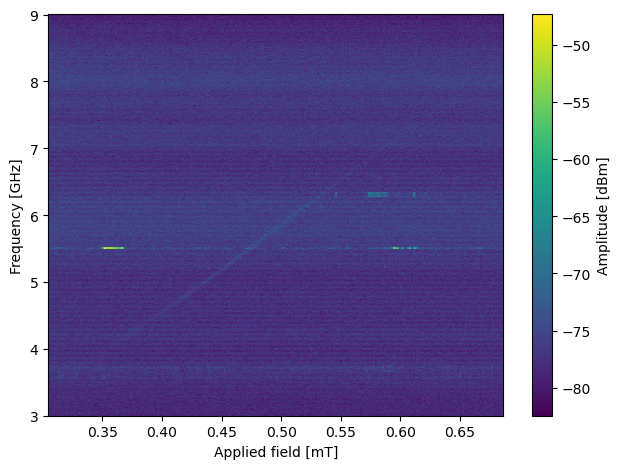

In [12]:
x_values = applied_field#bias_range#applied_field#applied_field#applied_field #bias_range#applied_field#bias_range*1000 # #applied_field #angle_range
y_values = frequency/1e9
X, Y = np.meshgrid(x_values, y_values)

plt.pcolormesh(X, Y, (waveforms.T), shading='auto', cmap='viridis')
plt.colorbar(label='Amplitude [dBm]')
plt.xlabel('Applied field [mT]')
plt.ylabel('Frequency [GHz]')
plt.tight_layout()
plt.show()

In [ ]:
class DataVizualizer:
    def __init__(self, path):
        self.path = path
        self.xlabel = ""
        print(path[0])
        # determine data type
        if self.path[0] == "f":
            self.xlabel = 'Applied field [mT]'
        elif self.path[0] == "b":
            self.xlabel = 'Bias current [mA]'
        elif self.path[0] == "a":
            self.xlabel = 'Angle [deg]'
        
        self.load_data()
        
    def load_data(self):
        #name = 'field_sweep/3-5_X6_L2R4_2_0mA_82deg.h5'
        
        ans = input("Confirm loading? [y/n]")
        if ans == 'y':
            with h5py.File(self.path, 'r') as f:
                self.applied_field = f['applied_field'][:]
                self.waveforms = f['waveforms'][:]
                self.frequency = f['frequency'][:]
            print("Data loaded!")
            print("Time:", time.strftime("%H:%M:%S", time.localtime()))
        else: 
            print("Loading cancelled!")
    
    
    def plot_data(self):
        x_values = self.applied_field #bias_range*1000 # #applied_field #angle_range
        y_values = self.frequency/1e9
        y_values = y_values
        X, Y = np.meshgrid(x_values, y_values)


        plt.pcolormesh(X, Y, (self.waveforms.T), shading='gouraud', )#vmax=-60
        #plt.xlim(1.1, 2.2)
        #plt.ylim(3.3, 3.7)
        plt.colorbar(label='Amplitude [dBm]')
        
        
        plt.xlabel(self.xlabel)
        plt.ylabel('Frequency [GHz]')
        #plt.ylim(5,6)
        plt.tight_layout()
        plt.show()
    

b
Data loaded!
Time: 12:46:23


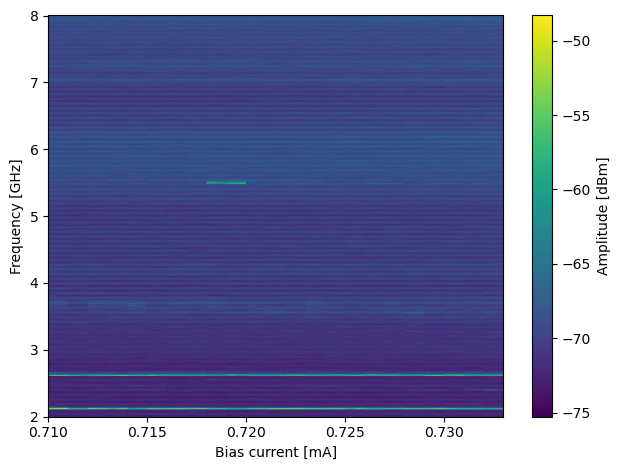

In [174]:
path = "bias_sweep/3-5_X6_L2R3_2_0mA_82deg_field_11_5V_bias_sweep.h5"
DataVizualizer(path).plot_data()

In [149]:
"field_sweep/morePath"[0]


'f'

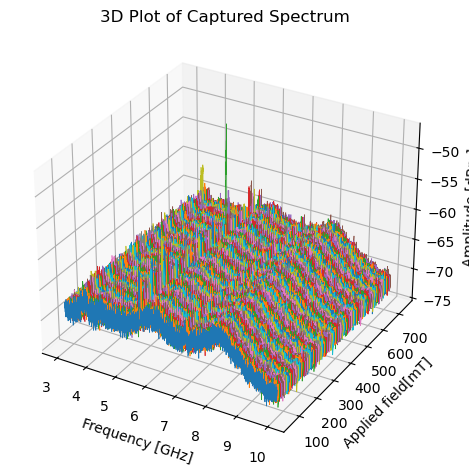

In [16]:
# Plotting in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Loop through the Fourier Transforms and plot them
for i, ft in enumerate(waveforms):
    ax.plot(frequency/1e9, applied_field[i]*1000, zs=ft, zorder=-i,lw=0.5) #label=f"Signal {i+1}"
    
ax.set_xlabel('Frequency [GHz]')
ax.set_zlabel('Amplitude [dBm]')
ax.set_ylabel('Applied field[mT]')
ax.set_title('3D Plot of Captured Spectrum')
plt.tight_layout()

plt.show()

In [4]:
# Interactive 3D plot

colormap = 'Viridis'
vmin, vmax = -80, -55  # Fixed range in dBm


X, Y = np.meshgrid(frequency / 1e9, applied_field)
Z = np.array(waveforms)

fig = go.Figure(data=[go.Surface(
    x=X, y=Y, z=Z,
    colorscale=colormap,
    cmin=vmin, cmax=vmax,
    colorbar=dict(title="Amplitude [dBm]")
)])

fig.update_layout(
    width=800,
    height=600,
    scene=dict(
        xaxis_title='Frequency [GHz]',
        yaxis_title='Applied field [mT]',
        zaxis_title='Amplitude [dBm]'
    ),
    title='Interactive 3D Plot of Captured Spectrum',
    autosize=True, 
    showlegend=False
)

# Show the plot
fig.show()

NameError: name 'frequency' is not defined

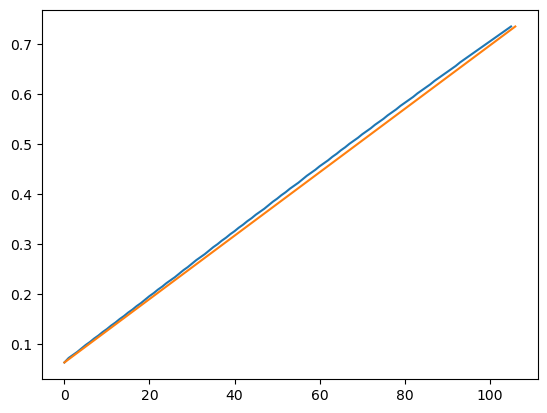

In [21]:
plt.plot(applied_field)
plt.plot([0, len(applied_field)], [applied_field[0], applied_field[-1]])
plt.show()

## Disconnect

In [179]:
vxm.Close()
fsv.close()
lna_psu.close()
magnet.close()

Connection closed
Connection closed
Connection closed
Connection closed
